In [1]:
directory = "/data/s1968653/MWG_output/"

In [2]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
import amuse.plot as plot
from tqdm import tqdm
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.lab import Rebound
from amuse.lab import Mercury
from amuse.community.ph4.interface import ph4
from amuse.io import write_set_to_file, read_set_from_file
from amuse.lab import Huayno

In [3]:
def random_positions_and_velocities(N_objects, sun_loc):
    positions = np.zeros((N_objects, 3)) | units.AU
    velocities = np.zeros((N_objects,3)) | units.kms
    
    m_sun = 1 | units.MSun
    m_oort = 0 | units.MSun
    for i in range(N_objects):
        a = np.random.uniform(4, 40) | units.AU
        e = np.random.uniform(0, 0.05)
        inclination = np.random.uniform(-5, 5) | units.deg
        true_anomaly = np.random.uniform (0, 360) | units.deg
        arg_of_periapsis = np.random.uniform(0, 360) | units.deg
        long_of_ascending_node = np.random.uniform(0, 360) | units.deg
        sun_and_oort = new_binary_from_orbital_elements(m_sun, m_oort, 
                                          a, e, true_anomaly, inclination, long_of_ascending_node, arg_of_periapsis, G=constants.G)
        positions[i] = (sun_and_oort[1].x+sun_loc[0]), (sun_and_oort[1].y+sun_loc[1]), (sun_and_oort[1].z+sun_loc[2])
        velocities[i]= sun_and_oort[1].vx, sun_and_oort[1].vy, sun_and_oort[1].vz
    return positions, velocities

In [4]:
def merge_two_bodies(bodies, particles_in_encounter):
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Collision:")
    print("Two objects (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    
    if particles_in_encounter[0].mass == 0 | units.MSun:
        bodies.remove_particle(particles_in_encounter[0])
    elif particles_in_encounter[1].mass == 0 | units.MSun:
        bodies.remove_particle(particles_in_encounter[1])
    elif particles_in_encounter[0].mass == 0 | units.MSun and particles_in_encounter[1].mass == 0 | units.MSun:
        bodies.remove_particles(particles_in_encounter)

In [5]:
def resolve_collision(collision_detection, gravity_code, gravity_bridge, bodies, time):
    print("We have a collision.")
    print("This happened at time=", time.in_(units.yr))
    for ci in range(len(collision_detection.particles(0))): 
        encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
        colliding_objects = encountering_particles.get_intersecting_subset_in(bodies)
        merge_two_bodies(bodies, colliding_objects)
        bodies.synchronize_to(gravity_bridge.particles)

In [6]:
#Here we generate a basic solarsystem, with only the gas giants
from amuse.ext.solarsystem import new_solar_system

def create_system():
    
    system = new_solar_system()
    system = system[system.mass > 10**-5 | units.MSun]
    return system
    
    
basic_giants_system = create_system()

|S11


In [7]:
#Define the number of Oort objects and create random velocities and positions
N_objects = 10**2
sun_loc = [basic_giants_system[0].x.in_(units.AU), basic_giants_system[0].y.in_(units.AU), basic_giants_system[0].z.in_(units.AU)]
positions, velocities = random_positions_and_velocities(N_objects, sun_loc)

In [8]:
#Here we add the Oort cloud objects, according to a chosen distribution
def add_comet_objects(system, N_objects, rand_pos, rand_vel):
    
    for i in tqdm(range(N_objects)):
        oort = Particles(1)
        oort.name = "OORT_" + str(i)
        oort.mass = 0.0 | units.MSun
        oort.radius = (2.3 | units.km).in_(units.RSun) #This is purely non-zero for collisional purposes
        oort.position = (rand_pos[i, 0], rand_pos[i, 1], rand_pos[i, 2])
        oort.velocity = (rand_vel[i, 0], rand_vel[i, 1], rand_vel[i, 2])
        oort.position += (1, 0, 0) * (8.5 | units.kpc)
        oort.velocity += (0,1,0) * (220 | units.kms)
        
        system.add_particle(oort)
    for i in range(5):
        system[i].position += (1, 0, 0) * (8.5 | units.kpc)
        system[i].velocity += (0,1,0) * (220 | units.kms)
    return system

complete_system = add_comet_objects(basic_giants_system, N_objects, positions, velocities)

100%|██████████| 100/100 [00:00<00:00, 527.86it/s]


In [9]:
#Here we generate a galactic potential 

class MilkyWay_galaxy(object):
    def __init__(self, 
                 Mb=1.40592e10| units.MSun,
                 Md=8.5608e10| units.MSun,
                 Mh=1.07068e11 | units.MSun):
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh

    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +numpy.log(c) + 1.02/(1+d1**1.02) \
                           - numpy.log(1.0 +d1**1.02) )
        return 2*(pot_bulge+pot_disk+ pot_halo) 
                # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax= force_bulge*x + force_disk*x  + force_halo*x/r
        ay= force_bulge*y + force_disk*y  + force_halo*y/r
        az= force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az
    
MW_potential = MilkyWay_galaxy()

In [10]:
final_system = complete_system

In [11]:
#Here we perform the conversion for the system
converter_length = get_orbital_elements_from_binary(final_system[0:2], G = constants.G)[2].in_(units.AU)
final_converter=nbody_system.nbody_to_si(final_system.mass.sum(), 
                                   converter_length)
#(final_system[0].position.length()).in_(units.AU)

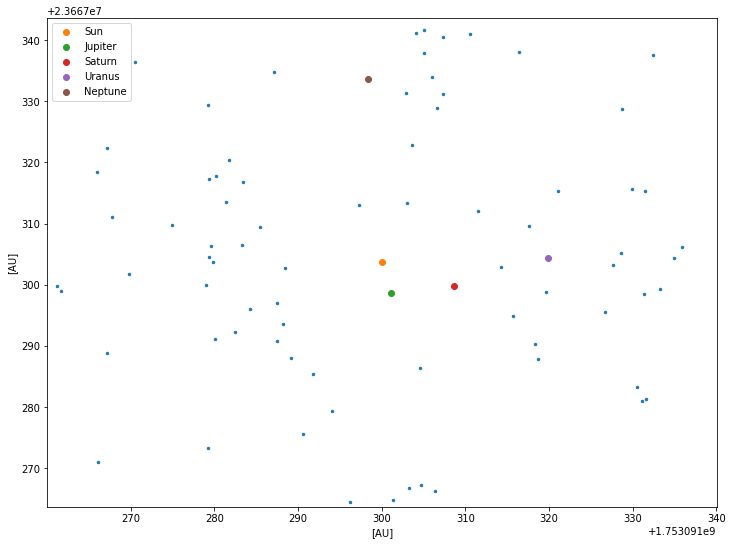

  1%|          | 52/10000 [21:40<59:50:20, 21.65s/it]

The distance from  Jupiter  to the sun is  5.19015344399 AU
The distance from  Saturn  to the sun is  9.40647434848 AU
The distance from  Uranus  to the sun is  19.8129693213 AU
The distance from  Neptune  to the sun is  29.9641773683 AU
The amount of currently escaped comets is  13
The amount of dead comets is  2
The centre of mass velocity is  [0.0131048416041, 0.0047570354686, -0.000442075355866] kms


  1%|          | 52/10000 [21:55<69:54:23, 25.30s/it]

wrapped<wrapped<wrapped<wrapped<function: int get_position(int index_of_the_particle)
output: double x, double y, double z, int __result>>>>


KeyboardInterrupt: 

In [12]:
#Here we evolve the basic system, with Milky way potential
def MWG_evolver(particle_system, potential, converter, N_objects, end_time=4*10**3, time_step=0.1):
    
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    if N_objects > 2*10**3:
        gravity_code = Mercury(final_converter)
    else:
        gravity_code = Huayno(final_converter)
    
    stopping_condition = gravity_code.stopping_conditions.collision_detection
    stopping_condition.enable()
    
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    gravity_bridge = 0
    gravity_bridge = bridge.Bridge(use_threading=False)
    gravity_bridge.add_system(gravity_code, (potential,) )
    gravity_bridge.timestep = 10 |units.yr
    
    times = np.arange(0., end_time, time_step) | units.yr
    
    dead_comets = []
    for i in tqdm(range(len(times))):
        gravity_bridge.evolve_model(times[i])
        while stopping_condition.is_set() and len(stopping_condition.particles(0)) != 0 and len(stopping_condition.particles(1)) != 0:
            resolve_collision(stopping_condition, gravity_code, gravity_bridge, particle_system, times[i])
            ch_g2l.copy()
            gravity_bridge.evolve_model(times[i])
        ch_g2l.copy()
        
        
        if i%(50) == 0:
            write_set_to_file(particle_system, directory + 'MWG_run4_time=' +str(np.log10(times[i].value_in(units.yr)))[0:5] +'.hdf5', format='hdf5', overwrite_file = True)
        
        out_of_bounds, escaped_comets = [], []
        for i in range(len(particle_system)):
            if (particle_system[i].position-particle_system[0].position).length() > 500 | units.AU:
                escaped_comets.append(particle_system[i].name)
                if (particle_system[i].position-particle_system[0].position).length() > 250000 | units.AU:
                    out_of_bounds.append(particle_system[i])
                    dead_comets.append(particle_system[i])
        for particle in out_of_bounds:
            particle_system.remove_particle(particle)
            particle_system.synchronize_to(gravity_bridge.particles)
            
        for i in range(1, 5):
            print("The distance from ", names[i], " to the sun is ", (particle_system[i].position-particle_system[0].position).length().in_(units.AU))
        
        print("The time is ", times[i])
        print("The amount of currently escaped comets is ", len(escaped_comets))
        print("The amount of dead comets is ", len(dead_comets))
        print("The centre of mass velocity is ", (particle_system.center_of_mass_velocity()-particle_system[0].velocity).in_(units.kms))
        
    print(particle_system)
        
    gravity_bridge.stop()
    write_set_to_file(particle_system, directory + 'MWG_run4_final.hdf5', format='hdf5', overwrite_file = True)
    print("The escaped comets are", escaped_comets)
    print("The dead comets are", dead_comets)
    return particle_system

MWG_evolved_system = MWG_evolver(final_system, MW_potential, final_converter, N_objects, end_time= 10**8, time_step= 10**5)